<a href="https://colab.research.google.com/github/okaybuyukdeveci/TransferLearningWFood101/blob/main/Transfer_learning_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with Tensorflow Part 3: Scaling up


In [ ]:
# dowland helper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-11-30 07:53:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-30 07:53:13 (90.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import series of helper funcitons for our notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys,walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's dowloand it.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-11-30 07:58:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.9MB/s    in 71s     

2024-11-30 07:59:21 (21.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test"

In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caesar_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_fo

In [ ]:
# setup data inputs

import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle = False)# dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog mdel with transfer learning on %10 of 101 food classes

Here are the steps we are going to take:

*   Create a ModelCheckpoint callback
*   Create a data augmentation layer to build data augmentation right into the model
*  Build a headless(no top layers) Functional EfficientNetB0 backboned-model (we will create our own output layer)
*   Compile our model
*   Feature extract for 5 full passes (5 epochs on the train dataset and validation on %15 of the test data, to save epoch time)













In [ ]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only= True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setup data augmentatiton

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    #layers.Rescaling(1/255.)#resclae inputs of images to between 0 % 1, required for models like ResNet50
],name="data_augmentation")

In [ ]:
# setup the base model and freeze its layers (this will extract feautres)

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# setuo model arhitecture with trainable top layerse

inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)#augment images (only happends during training phase)
x=base_model(x,training=False)# put the base model in inference mode so weights which need to stay frozen,stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs= layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax",name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)

In [ ]:
# get a summary of model we have created

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit

history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 63s 202ms/step - accuracy: 0.1279 - loss: 4.1035 - val_accuracy: 0.3652 - val_loss: 2.8121
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.4212 - loss: 2.5893 - val_accuracy: 0.4505 - val_loss: 2.2341
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 177ms/step - accuracy: 0.4934 - loss: 2.1623 - val_accuracy: 0.5493 - val_loss: 1.8661
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.5316 - loss: 1.9391 - val_accuracy: 0.5583 - val_loss: 1.7942
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - accuracy: 0.5644 - loss: 1.7881 - val_accuracy: 0.6081 - val_loss: 1.6074


In [ ]:
# evaluate on the whole test dataset

feature_extraction_results= model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5546 - loss: 1.7140


[1.6161385774612427, 0.5747326612472534]

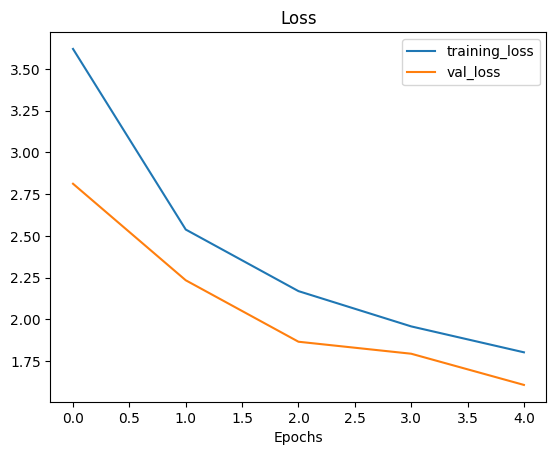

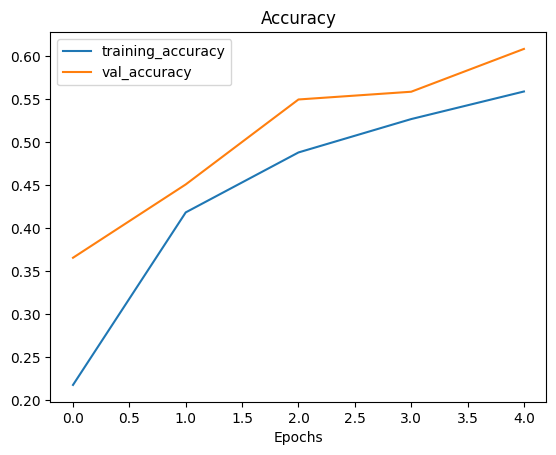

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

# Fine - Tuning

In [ ]:
# Unfreeze all of the layers in the base model

base_model.trainable=True

# Refreeze every layer except the last 5

for layer in base_model.layers[:-5]:
  layer.trainable=False


In [ ]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),# learning rate lowered by 10x
              metrics=["accuracy"])


In [ ]:
# What layers in the model are trainable ?

for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check which layers are trainable in our base model

for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs=10 # model has already done 5 epochs(feature extraction), this is the total number of epochs we're after (5+5=10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 184ms/step - accuracy: 0.5757 - loss: 1.7445 - val_accuracy: 0.5016 - val_loss: 1.9607
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.6296 - loss: 1.5378 - val_accuracy: 0.5426 - val_loss: 1.7533
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.6516 - loss: 1.4413 - val_accuracy: 0.5927 - val_loss: 1.6115
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.6537 - loss: 1.4049 - val_accuracy: 0.5787 - val_loss: 1.6327
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.6719 - loss: 1.3187 - val_accuracy: 0.6250 - val_loss: 1.4409
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.6826 - loss: 1.2685 - val_accuracy: 0.5922 - val_loss: 1.4947


In [ ]:
# Evalute on the whole test data

all_classes_10_percent_fine_tune_results=model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.5546 - loss: 1.7140


[1.6161385774612427, 0.5747326612472534]

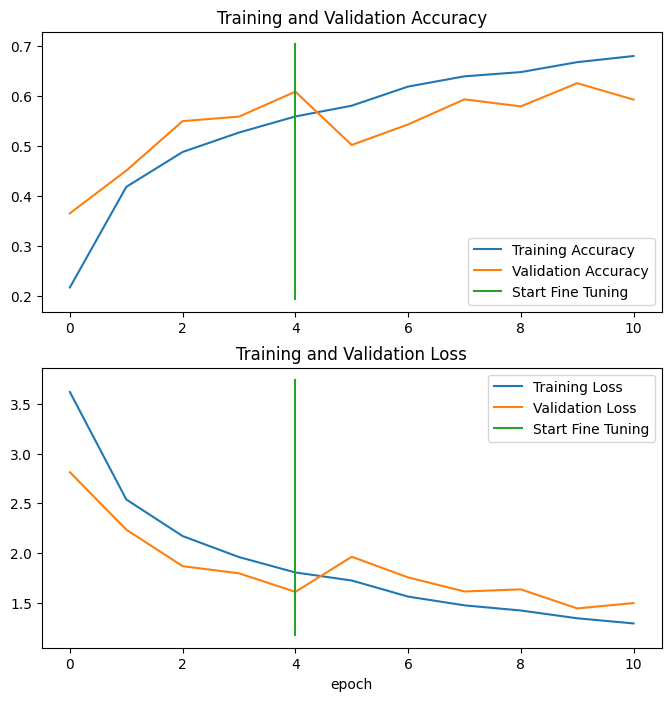

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external applicaiton, we''ll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuning model

model.save("drive/MyDrive/tensorflow/101_food_classes_10_percent_save_big_dog_model.keras")

In [ ]:
# load an evaluate saved model

loaded_model=tf.keras.models.load_model("drive/MyDrive/tensorflow/101_food_classes_10_percent_save_big_dog_model.keras")

In [ ]:
# Evaluate loaded model and compare perfomance to pre-saved model

loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 79ms/step - accuracy: 0.5290 - loss: 1.8173


[1.6812045574188232, 0.5574257373809814]

In [ ]:
# The results from our loaded_model (above should be very similar to the results below)
all_classes_10_percent_fine_tune_results

[1.6161385774612427, 0.5747326612472534]

# Evaluating the perfomance of the big dog model across all different classes

In [ ]:
import tensorflow as tf
# Dowland pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-11-30 09:55:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  14.5MB/s    in 3.1s    

2024-11-30 09:55:48 (14.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model.keras")

ValueError: File not found: filepath=/content/06_101_food_class_10_percent_saved_big_dog_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_dowloaded_model=model.evaluate(test_data)
results_dowloaded_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5546 - loss: 1.7140


[1.6161385774612427, 0.5747326612472534]

# Making predictions with our trained model


In [ ]:
# Make predictions with model

preds_probs = model.predict(test_data,verbose=1) # set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step


In [ ]:
# how many predictions are there?
len(preds_probs)

25250

In [ ]:
# What is the shape of our predictions ?
preds_probs.shape

(25250, 101)

In [ ]:
# Let' s see what the first 10 pred look like
preds_probs[:10]

array([[3.37185085e-01, 1.74602971e-03, 1.65904939e-01, ...,
        1.44813821e-04, 5.57000982e-03, 5.55642918e-02],
       [9.66935933e-01, 1.35907874e-06, 6.47131412e-04, ...,
        1.18780532e-03, 6.39398763e-07, 4.17781757e-06],
       [3.54216844e-01, 2.72553298e-03, 3.85957770e-03, ...,
        1.36710389e-03, 6.50115078e-04, 2.67075538e-03],
       ...,
       [4.90314931e-01, 8.22978836e-06, 1.49566121e-03, ...,
        9.26528797e-02, 2.15257853e-04, 2.81556917e-04],
       [8.84442553e-02, 1.31923018e-03, 9.24353451e-02, ...,
        1.86551525e-03, 3.70016875e-04, 5.78461040e-04],
       [2.62746453e-01, 9.18505248e-05, 3.06621497e-03, ...,
        1.30633665e-02, 5.07948716e-05, 2.98858224e-03]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]),sum(preds_probs[0])

(array([3.3718508e-01, 1.7460297e-03, 1.6590494e-01, 1.5990755e-06,
        7.5104963e-06, 2.5331978e-05, 1.4925755e-03, 2.6242313e-04,
        3.8187865e-02, 1.1352036e-03, 3.6210124e-05, 1.4937026e-04,
        3.1675410e-03, 5.8141704e-06, 6.7937435e-03, 1.4802712e-03,
        3.6855543e-04, 2.5951117e-03, 1.1273924e-03, 1.6796703e-05,
        5.5259280e-04, 2.5931955e-04, 7.2021596e-04, 4.5226738e-04,
        7.3501660e-04, 2.4166089e-03, 9.6619793e-04, 3.3594606e-05,
        1.1253657e-01, 3.0520842e-03, 2.0944184e-05, 2.6926794e-03,
        4.2676860e-03, 2.0468380e-05, 6.5878276e-03, 1.5794032e-04,
        7.3135894e-04, 1.5921768e-03, 1.0042286e-02, 1.1562678e-04,
        3.9652907e-04, 3.5186388e-04, 1.8145381e-03, 1.5324862e-05,
        6.6643937e-05, 4.3545922e-04, 9.4272930e-04, 4.8936426e-04,
        1.6178748e-05, 2.5360500e-03, 2.1961462e-03, 3.4268345e-05,
        9.7229108e-02, 3.5619277e-03, 1.1692450e-04, 2.7755855e-02,
        7.1346383e-03, 2.0102160e-03, 1.3273393e

Our model outputs a prediction probability array ( with N number of variables where N is the number of classes) for each sample passed to the predict method

In [ ]:
# We get one prediction probabiliity per class (in our case there's 101 prediction probabilities)

print(f"number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"what prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

number of prediction probabilities for sample 0: 101
what prediction probability sample 0 looks like:
 [3.3718508e-01 1.7460297e-03 1.6590494e-01 1.5990755e-06 7.5104963e-06
 2.5331978e-05 1.4925755e-03 2.6242313e-04 3.8187865e-02 1.1352036e-03
 3.6210124e-05 1.4937026e-04 3.1675410e-03 5.8141704e-06 6.7937435e-03
 1.4802712e-03 3.6855543e-04 2.5951117e-03 1.1273924e-03 1.6796703e-05
 5.5259280e-04 2.5931955e-04 7.2021596e-04 4.5226738e-04 7.3501660e-04
 2.4166089e-03 9.6619793e-04 3.3594606e-05 1.1253657e-01 3.0520842e-03
 2.0944184e-05 2.6926794e-03 4.2676860e-03 2.0468380e-05 6.5878276e-03
 1.5794032e-04 7.3135894e-04 1.5921768e-03 1.0042286e-02 1.1562678e-04
 3.9652907e-04 3.5186388e-04 1.8145381e-03 1.5324862e-05 6.6643937e-05
 4.3545922e-04 9.4272930e-04 4.8936426e-04 1.6178748e-05 2.5360500e-03
 2.1961462e-03 3.4268345e-05 9.7229108e-02 3.5619277e-03 1.1692450e-04
 2.7755855e-02 7.1346383e-03 2.0102160e-03 1.3273393e-02 5.9766138e-05
 1.0410897e-05 2.0328648e-03 8.3383769e-03 5.

In [ ]:
b# Get the pred classes of each label

pred_classes = preds_probs.argmax(axis=1)

# How do they look?

pred_classes[:10]


array([ 0,  0,  0,  0,  0, 78, 29,  0,  9,  0])

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the test labels.

In [ ]:
# to get our test labels we need to unravel our test_data BatchDataset

y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there ?
len(y_labels)

25250

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

# Evaluating our model's predictions
one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_dowloaded_model

[1.6161385774612427, 0.5747326612472534]

In [ ]:
# lets try scikit-learn's accuracy score function and see what it comes up with

from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,y_pred=pred_classes)
sklearn_accuracy

0.5747326732673267

In [ ]:
# does this metrics come close to our model's evaluate results

import numpy as np
np.isclose(results_dowloaded_model[1],sklearn_accuracy)

True

# Let s get visual : making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names=test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# we need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix



def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changed (plot x-labels vertically) ###

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20
                      savefig=True)

In [114]:
# lets keep the evaluation train going, time or a classification report

from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.17      0.22       250
           1       0.43      0.74      0.54       250
           2       0.57      0.58      0.58       250
           3       0.79      0.48      0.59       250
           4       0.54      0.41      0.47       250
           5       0.37      0.40      0.39       250
           6       0.78      0.67      0.72       250
           7       0.83      0.68      0.75       250
           8       0.26      0.50      0.35       250
           9       0.35      0.61      0.44       250
          10       0.46      0.40      0.43       250
          11       0.71      0.56      0.62       250
          12       0.69      0.58      0.63       250
          13       0.44      0.58      0.50       250
          14       0.44      0.58      0.50       250
          15       0.42      0.32      0.36       250
          16       0.63      0.50      0.56       250
          17       0.40    

In [116]:
# get a dictionary of the classification report

classification_report_dict = classification_report(y_labels,
                                                     pred_classes,
                                                     output_dict=True)
classification_report_dict

{'0': {'precision': 0.3088235294117647,
  'recall': 0.168,
  'f1-score': 0.21761658031088082,
  'support': 250.0},
 '1': {'precision': 0.42824074074074076,
  'recall': 0.74,
  'f1-score': 0.5425219941348973,
  'support': 250.0},
 '2': {'precision': 0.5725490196078431,
  'recall': 0.584,
  'f1-score': 0.5782178217821782,
  'support': 250.0},
 '3': {'precision': 0.7933333333333333,
  'recall': 0.476,
  'f1-score': 0.595,
  'support': 250.0},
 '4': {'precision': 0.5421052631578948,
  'recall': 0.412,
  'f1-score': 0.4681818181818182,
  'support': 250.0},
 '5': {'precision': 0.373134328358209,
  'recall': 0.4,
  'f1-score': 0.3861003861003861,
  'support': 250.0},
 '6': {'precision': 0.7767441860465116,
  'recall': 0.668,
  'f1-score': 0.7182795698924731,
  'support': 250.0},
 '7': {'precision': 0.8325123152709359,
  'recall': 0.676,
  'f1-score': 0.7461368653421634,
  'support': 250.0},
 '8': {'precision': 0.2641509433962264,
  'recall': 0.504,
  'f1-score': 0.3466299862448418,
  'support

In [120]:
# create empty dictionary

class_f1_scores = {}
# loop through classification report items
for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.21761658031088082,
 'baby_back_ribs': 0.5425219941348973,
 'baklava': 0.5782178217821782,
 'beef_carpaccio': 0.595,
 'beef_tartare': 0.4681818181818182,
 'beet_salad': 0.3861003861003861,
 'beignets': 0.7182795698924731,
 'bibimbap': 0.7461368653421634,
 'bread_pudding': 0.3466299862448418,
 'breakfast_burrito': 0.4444444444444444,
 'bruschetta': 0.4267241379310345,
 'caesar_salad': 0.6233183856502242,
 'cannoli': 0.62882096069869,
 'caprese_salad': 0.5008635578583766,
 'carrot_cake': 0.49914529914529915,
 'ceviche': 0.35990888382687924,
 'cheese_plate': 0.56,
 'cheesecake': 0.4108527131782946,
 'chicken_curry': 0.421505376344086,
 'chicken_quesadilla': 0.6146788990825688,
 'chicken_wings': 0.6759098786828422,
 'chocolate_cake': 0.5070422535211268,
 'chocolate_mousse': 0.32242990654205606,
 'churros': 0.7308533916849015,
 'clam_chowder': 0.7051546391752578,
 'club_sandwich': 0.6584362139917695,
 'crab_cakes': 0.3770491803278688,
 'creme_brulee': 0.7404426559356136,
 'cr

In [121]:
# Turn f1-scores into dataframe for visualization

import pandas as pd
f1_scores_df = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                             "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [123]:
f1_scores_df.head(10)

class_names  f1-score
33            edamame  0.956693
75                pho  0.835821
63           macarons  0.824885
86            sashimi  0.816406
54  hot_and_sour_soup  0.808511
45      frozen_yogurt  0.800774
69            oysters  0.794979
32          dumplings  0.794677
65            mussels  0.791075
64          miso_soup  0.786948

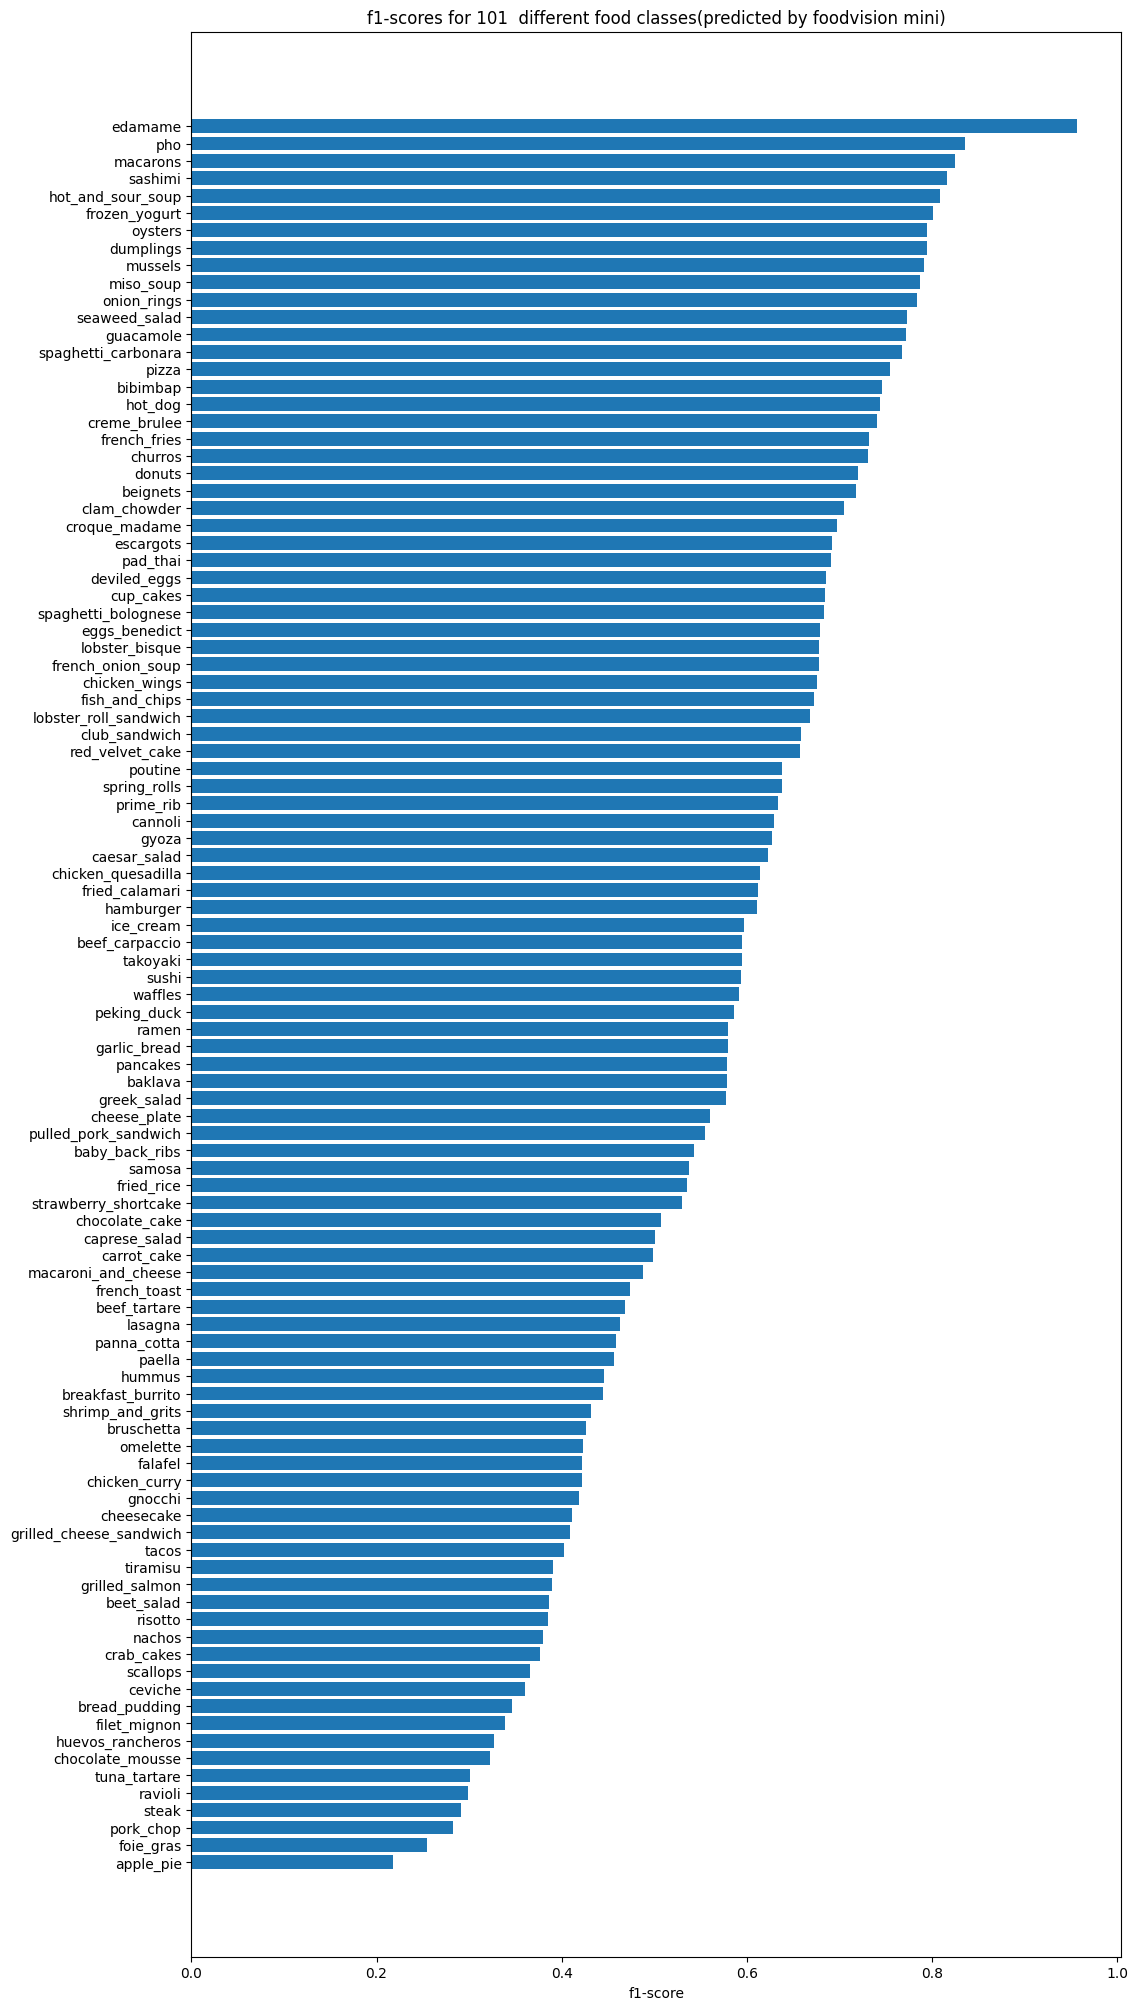

In [127]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("f1-score")
ax.set_title("f1-scores for 101  different food classes(predicted by foodvision mini)")
ax.invert_yaxis();
#

Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset(images of our own, we'll see this later on.)

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, spesifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be te same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1

In [128]:
# Create a funtion to load and prepare images

def load_and_prep_image(filename, img_shape=224, scale=True):
    # Read the image file
    img = tf.io.read_file(filename)

    # Decode image into tensor
    img = tf.image.decode_image(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])

    # Scale the image if required
    if scale:
        img = img / 255.0

    return img


Time to write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original images along with the model's predictions, prediction probability and truth label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


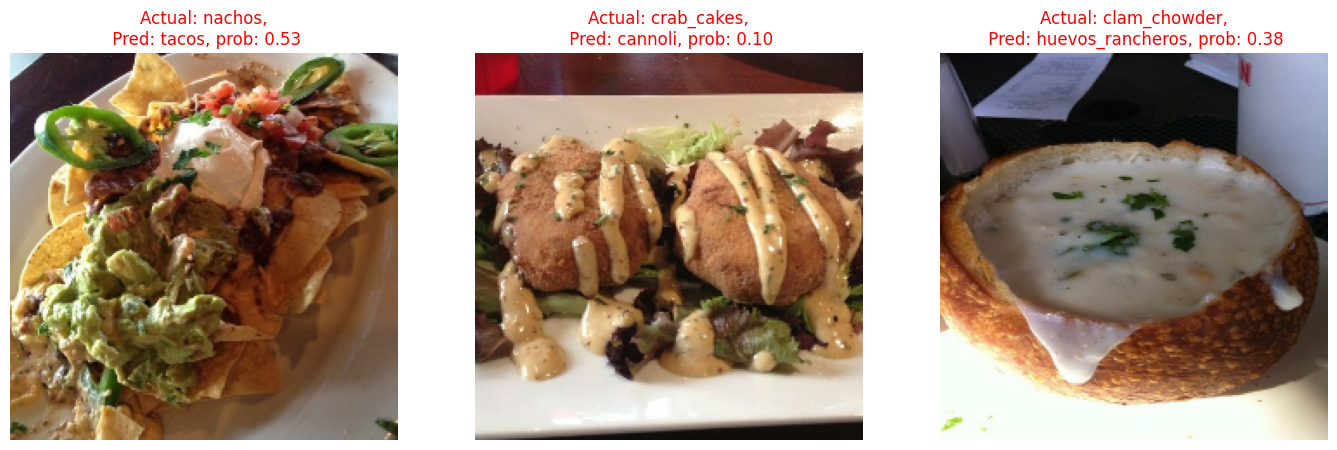

In [130]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded)
    pred_class = class_names[pred_prob.argmax()]

    # Plot the images
    plt.subplot(1, 3, i + 1)
    plt.imshow(img / 255.0)
    title_color = "g" if class_name == pred_class else "r"
    plt.title(
        f"Actual: {class_name},\n Pred: {pred_class}, prob: {pred_prob.max():.2f}",
        c=title_color
    )
    plt.axis(False)


## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes, max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesnt match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predicitons at the top.)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction

In [133]:
# 1. Get all of the image file paths in the test dataset

filepaths=[]
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [147]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1),
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})

pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0       0   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      38   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100      56   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname  y_pred_classname  
0       0.476672        apple_pie         apple_pie  
1       0.829621        apple_pie         apple_pie  
2       0.236299        apple_pie         apple_pie  
3       0.165761        apple_pie    fish_and_chips  
4       0.419041        apple_pie     bread_pudding  
...          ...              ...               ...  
25245   0.967858          waffles           waffles  
25246   0.955007          waffles           waffles  
25247   0.528406          waffles  huevos_rancheros  
25248   0.512235          waffles           waffles  
25249   0.458527          waffles           waffles  

[25250 rows x 6 columns]

In [149]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       0   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      38   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.476672        apple_pie        apple_pie          True  
1   0.829621        apple_pie        apple_pie          True  
2   0.236299        apple_pie        apple_pie          True  
3   0.165761        apple_pie   fish_and_chips         False  
4   0.419041        apple_pie    bread_pudding         False

In [150]:
# 4. Sort our DataFrame to have most wrong predictions at the top

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False).head(100)
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
22044  b'/content/101_food_classes_10_percent/test/se...      88       5   
15826  b'/content/101_food_classes_10_percent/test/ma...      63      29   
22     b'/content/101_food_classes_10_percent/test/ap...       0     100   
17816  b'/content/101_food_classes_10_percent/test/pa...      71      70   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
22606  b'/content/101_food_classes_10_percent/test/sp...      90       1   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
19899  b'/content/101_food_classes_10_percent/test/pr...      79       1   
9073   b'/content/101_food_classes_10_percent/test/fa...      36      26   
21216  b'/content/101_food_classes_10_percent/test/ri...      84      70   
14697  b'/content/101_food_classes_10_percent/test/ic...      58      31   
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
19374  b'/content/101_food_classes_10_percent/test/po...      77       1   
18672  b'/content/101_food_classes_10_percent/test/pe...      74       1   
920    b'/content/101_food_classes_10_percent/test/be...       3      81   
13094  b'/content/101_food_classes_10_percent/test/gy...      52      32   
16209  b'/content/101_food_classes_10_percent/test/mi...      64      81   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   

       pred_conf       y_true_classname y_pred_classname  pred_correct  
23631   0.998498   strawberry_shortcake  red_velvet_cake         False  
22044   0.995049          seaweed_salad       beet_salad         False  
15826   0.993716               macarons        cup_cakes         False  
22      0.992191              apple_pie          waffles         False  
17816   0.991729                 paella         pad_thai         False  
10847   0.991357         fried_calamari      onion_rings         False  
18001   0.991130               pancakes         omelette         False  
22606   0.990229    spaghetti_bolognese   baby_back_ribs         False  
23797   0.989734                  sushi          sashimi         False  
19899   0.986181              prime_rib   baby_back_ribs         False  
9073    0.986120                falafel       crab_cakes         False  
21216   0.985569                risotto         pad_thai         False  
14697   0.982958              ice_cream           donuts         False  
21810   0.981623               scallops        cup_cakes         False  
19374   0.981535              pork_chop   baby_back_ribs         False  
18672   0.979424            peking_duck   baby_back_ribs         False  
920     0.978488         beef_carpaccio            ramen         False  
13094   0.978460                  gyoza        dumplings         False  
16209   0.977680              miso_soup            ramen         False  
15359   0.976338  lobster_roll_sandwich        hamburger         False

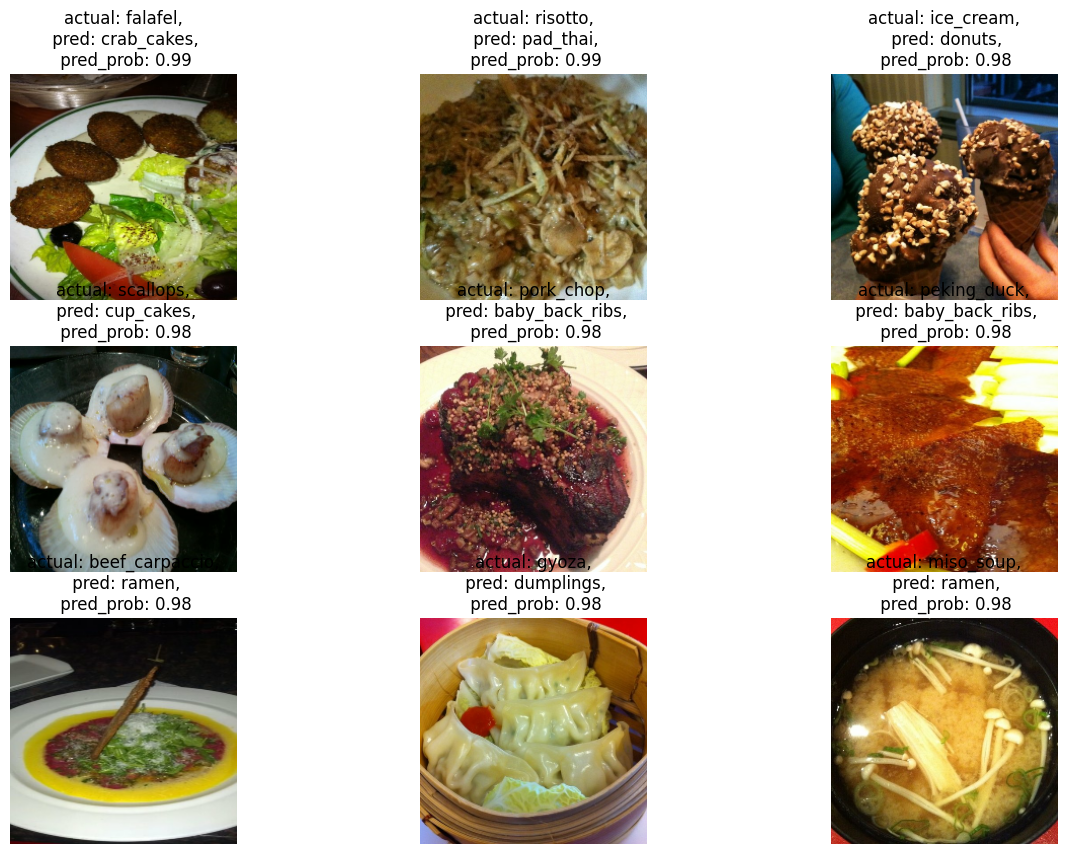

In [157]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability

images_to_view = 9
start_index= 10
plt.figure(figsize=(15,10))
for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1],scale=False)
  _, _, _, _, pred_prob,y_true_classname, y_pred_classname, _,=row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname},\n pred: {y_pred_classname},\n pred_prob: {pred_prob:.2f}")
  plt.axis(False)
#

## Test out the big dog model on our custom images



In [158]:
# Get custom images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip


--2024-12-01 11:09:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  66.4MB/s    in 0.2s    

2024-12-01 11:09:43 (66.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [159]:
unzip_data("custom_food_images.zip")

In [160]:
# Get the custom food iamges filepaths
custom_food_images = ["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


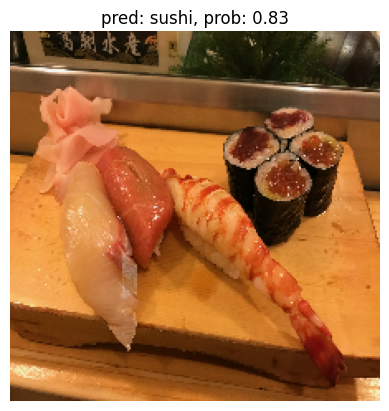

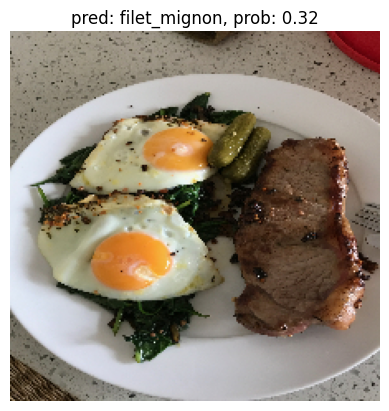

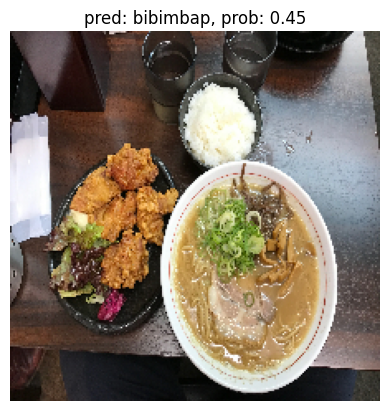

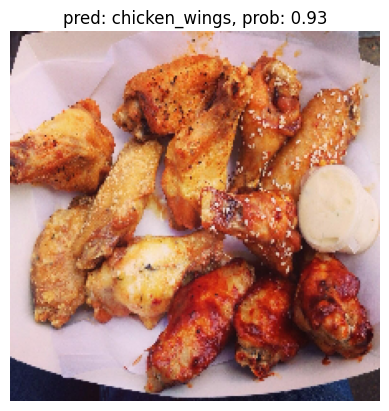

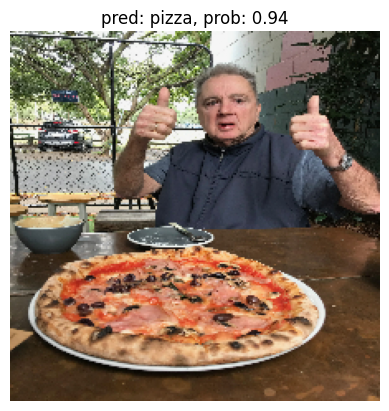

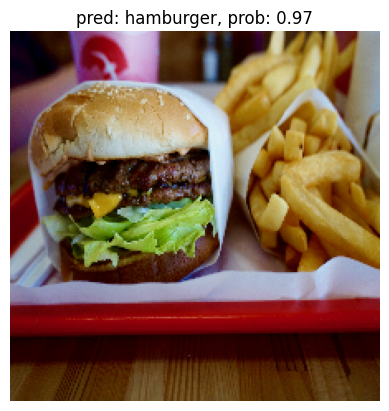

In [164]:
# make predictions and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)